<a href="https://colab.research.google.com/github/greyes69/Sentiment-Analysis-Project/blob/main/SentimentMoviesReviewsBERTVersion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import transformers
!pip install datasets
from datasets import load_dataset,load_dataset_builder
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# In case you are working local. No GPU available
#device = torch.device("cpu")

GPU is available. Using GPU: Tesla T4


In [4]:
# Load the IMDB dataset and understanding the features
dataset = load_dataset("imdb")
ds_builder = load_dataset_builder("imdb")
ds_builder.info.description
ds_builder.info.features

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [5]:
# Loading the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

train_dataset = dataset['train'].map(tokenize, batched=True, batch_size=len(dataset['train']))
test_dataset = dataset['test'].map(tokenize, batched=True, batch_size=len(dataset['test']))

# Format dataset for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:
# Define evaluation metrics
def compute_metrics(p):
    preds = torch.argmax(torch.from_numpy(p.predictions), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [9]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    eval_strategy="steps",
    eval_steps = 500,                # Evaluate and save every 500 batches
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=8,   # Batch size (small to fit in memory)
    per_device_eval_batch_size=16,   # Larger batch size for evaluation
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.015,               # Weight decay
    logging_dir="./logs",            # Directory for logs
    logging_steps=10,
    load_best_model_at_end=True,     # Early stopping
    save_total_limit=2,              # Limit the number of checkpoints
    gradient_accumulation_steps=4,
    save_strategy="steps"
)

In [10]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [11]:
# Train the model
trainer.train()
#-------------------------------------
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.181000,0.202984,0.921240,0.905132,0.941120,0.922775
1000,0.195600,0.216432,0.928400,0.932832,0.923280,0.928032
1500,0.081500,0.203455,0.930280,0.932112,0.928160,0.930132


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.181000,0.202984,0.921240,0.905132,0.941120,0.922775
1000,0.195600,0.216432,0.928400,0.932832,0.923280,0.928032
1500,0.081500,0.203455,0.930280,0.932112,0.928160,0.930132
2000,0.092700,0.256388,0.930960,0.928356,0.934000,0.931169


Test Accuracy: 0.9212


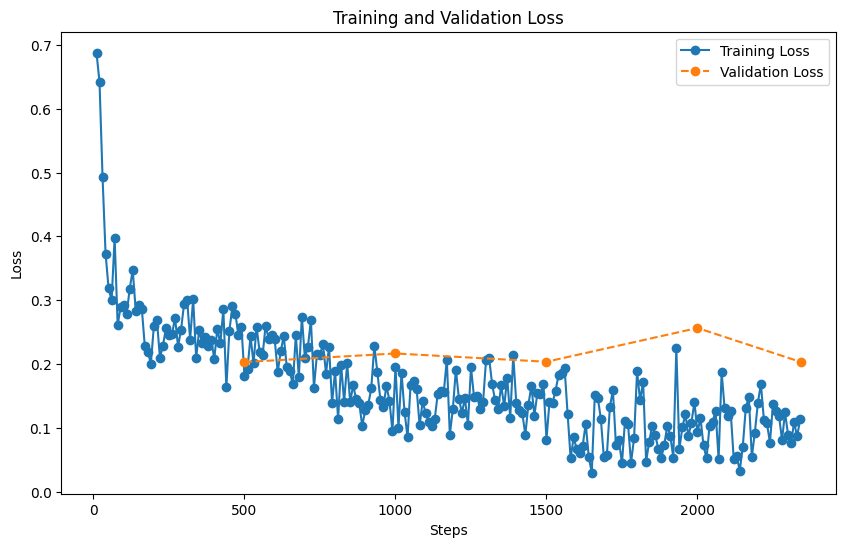

In [12]:
import matplotlib.pyplot as plt

# Extract the loss values from the Trainer logs
log_history = trainer.state.log_history

# Training and validation losses from log history
train_loss = [log['loss'] for log in log_history if 'loss' in log.keys()]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log.keys()]

# Logging steps for training and evaluation from log history
train_steps = [log['step'] for log in log_history if 'loss' in log.keys()]
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log.keys()]

# Plotting the losses as they evolve over training/evaluation
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker='o')
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='o', linestyle='--')

# Label the plot
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Save the plot as a PNG file
plt.savefig("TrainingVsValidationLossVersion1.png")

# Show the plot
plt.show()

In [13]:
trainer.save_model("best_modelVersion1")

In [14]:
# Access the best checkpoint and the corresponding step
best_checkpoint = trainer.state.best_model_checkpoint

# If best_model_checkpoint is not None, extract the step number from the checkpoint path
if best_checkpoint is not None:
    best_step = int(best_checkpoint.split('-')[-1])
    print(f"The best model was found at step {best_step} and saved in '{best_checkpoint}'")
else:
    print("No best model found.")

The best model was found at step 500 and saved in './results/checkpoint-500'


In [15]:
#best_step = trainer.state.best_trial
best_metric = trainer.state.best_metric
print(f"The best model was found with a metric value of {best_metric}.")

The best model was found with a metric value of 0.2029840052127838.


In [17]:
import numpy as np
# Get the predictions on the validation set
predictions_output = trainer.predict(test_dataset)

# Extract the predictions and true labels
logits = predictions_output.predictions  # Raw output (logits)
true_labels = predictions_output.label_ids  # Ground truth labels

# Convert logits to predicted class labels
pred_labels = np.argmax(logits, axis=1)

In [18]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(cm)

# Print the classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Confusion Matrix:
[[11267  1233]
 [  736 11764]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12500
           1       0.91      0.94      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

